# Evaluación del modelo

In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
import re
import math
import time
import glob
import gzip
import sys
import matplotlib.pyplot as plt
import matplotlib
import os
import random
import h5py
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

folder_fig="figures/Energy_21"

## Declaramos el Dataloader que se ha usado para entrenar la red

In [2]:
class EventsData(Dataset):
    def __init__(self,data_dir,per=100,batch_size=500):
        # Save the directory of the data
        self.data_dir = data_dir
        
        # Get the names of the files
        self.names=glob.glob(str(data_dir)+'*.hdf5')
        # Number of files in the dir
        self.size_dir=len(self.names)
        
        # Set the files acording to the percentage
        self.size_dir=math.ceil(len(self.names)*(per/100))
        self.names=self.names[0:self.size_dir]
        # Sort the files alphabetically
        self.names = sorted(self.names)
        #random.shuffle(self.names)
        
        # Get the number of events per file
        print(self.names[1])
        f = h5py.File(self.names[0],'r')
        self.size_file=f['y'].shape[0]
        
        # Get the total number of events
        self.total_events=0
        for name in self.names:
            f = h5py.File(name,'r')
            y = f['y']
            self.total_events+=y.shape[0]

        # Read the results from the Zenith and load them to RAM
        zn = h5py.File('Z_results_zenith.hdf5','r')
        dn = h5py.File('Distance_norm.hdf5','r')
        # Identify if the dataloader is loading train, validation or test results
        dataset_type = self.names[1][15]
        print(dataset_type)
        if dataset_type == 'r':
          print("Train dataset type")
          self.z_zenith = torch.tensor([zn['Train_Z']])
          self.distance = torch.tensor([dn['Train_Z']])
        if dataset_type == 'a':
          print("Validation dataset type")
          self.z_zenith = torch.tensor([zn['Val_Z']])
          self.distance = torch.tensor([dn['Val_Z']])
        if dataset_type == 'e':
          print("test dataset type")
          self.z_zenith = torch.tensor([zn['Test_Z']])
          self.distance = torch.tensor([dn['Test_Z']])
        
        self.z_zenith=torch.squeeze(self.z_zenith)
        self.distance=torch.squeeze(self.distance)
        print(self.z_zenith.size())
        # Load the whole dataset into the RAM
        self.data_big = torch.zeros(self.total_events,25,161)
        self.target_big = torch.zeros(self.total_events)
        

        print("Reading "+str(self.data_dir)+" with "+str(self.size_dir)+" files.")
        for a in range(len(self.names)):
            f = h5py.File(self.names[a],'r')
            # The input of the network will the same for the Zenith model, distance, etc
            self.data_big[(a*1000):(((a+1)*1000))]=torch.tensor(f['X1'][:,:,:,0])
            # For distance in the target data, use the second component 
            # As the dimentions for the X2 tensor are:
            # 0 -> Result from the BBFit
            # 1 -> Distance 
            # 2 -> Zc
            self.target_big[(a*1000):(((a+1)*1000))]=torch.tensor(f['y'][:,1])
            self.target_big[(a*1000):(((a+1)*1000))].size()
        



        # Number of iterations to finish the dataset
        self.batch_size=batch_size
        self.iters=math.floor(self.total_events/batch_size)
        self.iters_per_file= math.floor(self.size_file/batch_size)
        self.real_events=self.batch_size*self.iters

        print("There are "+str(self.total_events)+" events.")
        print("In "+str(self.size_dir)+" separate files.")
        print("Each file containing "+str(self.size_file)+" events.")
        print("In "+str(self.iters)+" iterations")
        print("The real number of events is: "+str(self.real_events))
        


    def get_len(self):
        return self.real_events
    
    def get_iter(self):
        # Returns the number of iteracions og getitem to finish the dataset
        return self.iters

    def get_batch(self, idx):
        # Get the file that shall be opened
        ind1=idx*self.batch_size
        ind2=((idx+1)*self.batch_size)
        
        
        data=self.data_big[ind1:ind2,:,:]
        target=torch.log10(self.target_big[ind1:ind2])
        Z=self.z_zenith[ind1:ind2]
        D=self.distance[ind1:ind2]
        
        # Get the events that will be extracted from the file
        #ind2=ind+self.batch_size
        
        data=data.unsqueeze(dim=3)
        target=target.unsqueeze(dim=1)
        
        
        
        #Only for conv with modulus
        data=data.transpose(1,3)
        data=data.transpose(2,3)    
        
        return data.float(),target.float(),Z.float(),D.float()

In [3]:
print("Test dataset:")
test_data=EventsData(data_dir='Mod_full_dist/test_data_fixed/', per=100, batch_size=1000);
print()

Test dataset:
Mod_full_dist/test_data_fixed/test_dataset_1.hdf5
e
test dataset type
torch.Size([120000, 2])
Reading Mod_full_dist/test_data_fixed/ with 120 files.
There are 120000 events.
In 120 separate files.
Each file containing 1000 events.
In 120 iterations
The real number of events is: 120000



## Declaramos la arquitectura de nuestra red, tiene que ser exactamente igual a que vamos a evaluar

In [4]:
# This class will contain the NN arquitecture, it will be pushed to the GPU
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        kernel_size=(2,10)
        
        #conv layer, sees 25x161x1 tensor
        self.conv1 = nn.Conv2d(1, 16, kernel_size,padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size,padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size,padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size,padding=1)

        
        self.pool = nn.MaxPool2d((2, 2))
        # Two more inputs for the mean and std of the Z component
        input_flatten = 6656 + 4
        hidden_1 = 600
        hidden_2 = 200
        hidden_3 = 50
        
        # linear layer (n_hidden -> hidden_2)
        self.fc1 = nn.Linear(input_flatten, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.mu = nn.Linear(hidden_3, 1)
        self.sigma = nn.Linear(hidden_3,1)
        
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.25)


    def forward(self, x,z,d):
        input_flatten = 6656
        # add sequence of convolutional and max pooling layers

        x = (F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
   
        #print(x.size())
        x = x.reshape(-1, input_flatten)
        x = torch.cat((x,z),dim=1)
        x = torch.cat((x,d),dim=1)

        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        mu = self.mu(x)
        sigma = torch.exp(self.sigma(x))
        return mu,sigma

## Pasamos los datos a la red, podemos seleccionar:
* La carpeta donde está el archivo
* El nombre del archivo que vamos a cargar
* El dispositivo donde vamos a correr la red: cuda o cpu

In [5]:
# Check if cuda is available and set as default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=Net()
print(net)
# Cargar aqui el archivo
net.load_state_dict(torch.load('Energy_21.pt'))
net.eval()
# This is where the values will be stored
target_temp=np.zeros([test_data.get_len(),1])
mu_temp=np.zeros([test_data.get_len(),1])
sigma_temp=np.zeros([test_data.get_len(),1])
MAE=0
MSE=0
for batch in range(test_data.get_iter()):
    # Get the data
    data,target,Z,D = test_data.get_batch(batch)
    # move tensors to GPU if CUDA is available
    data = data
    # Get the results from the foward pass to the CPU 
    # And get it as an numpy matrix
    mu,sigma = net(data,Z,D)
    
    # Get from tensors to numpy
    output = mu.detach().numpy()
    sigma = sigma.detach().numpy()
    target = target.numpy()
    # calculate the batch loss
    MAE += np.sum(np.abs(output-target))
    MSE += np.sum((output-target)**2)
    # Append to the historical value
    target_temp[(batch*1000):((batch+1)*1000)]=target
    sigma_temp[(batch*1000):((batch+1)*1000)]=sigma
    mu_temp[(batch*1000):((batch+1)*1000)]=output

Net(
  (conv1): Conv2d(1, 16, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(2, 10), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6660, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
  (mu): Linear(in_features=50, out_features=1, bias=True)
  (sigma): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## Cojo los valores de testeo

Algunas cosas cambiarán debido a los cambios en el preprocesado y las normalizaciones

In [6]:
# De los archivos, vamos a extraer la energía y el BBFIT
# Ya que el dataloader no nos los dá
f = h5py.File(test_data.names[0],'r')

# Inicializamos las matrices
zeta=f['y'][:,0] # Guardamos la componente z
energy=f['y'][:,1] # Guardamos la energía
bbfit_uz=f['X2'][:,0] # Guardamos la componente z del BBFIT
dist_t = f["X2"][:,1]

# Miramos el dataset entero ampliando las matrices
for name in test_data.names[1:]:
    f = h5py.File(name,'r')
    test_z_aux=f['y'][:,0] # Guardamos la componente z
    energy_aux=f['y'][:,1] # Guardamos la energía
    bbfit_uz_aux=f['X2'][:,0] # Guardamos la componente z del BBFIT
    txi2_aux = f["X2"][:,1]
    
    # Juntamos las matrices
    zeta=np.append(zeta,test_z_aux,axis=0)
    energy = np.append(energy,energy_aux,axis=0)
    bbfit_uz = np.append(bbfit_uz,bbfit_uz_aux,axis=0)
    dist_t = np.append(dist_t,txi2_aux,axis=0)

## Obteniendo el resto de parámetros

Obtengo el valor predicho como la media de los 100 valores que se predicen con DropOut activo, la Sigma como la media de las 100 Sigmas, y lo que llamamos *prediction interval* (PI) como la desviación en los valores predichos.

Los ángulos se pasan a grados, auque para cálculo de propagación de errores y otras cosas hay que usarlos en radianes tal y como salen de la red.

In [7]:
# Energia y desviacion predichas

log = True

if log:
    print("Net output is log")
    energy_p = 10.0**mu_temp
    energy_std = energy_p*np.log(10.0)*sigma_temp
else:
    print("Net output is not log")
    energy_p = mu_temp
    energy_std = sigma_temp

Net output is log


In [8]:
energy_std_rel = energy_std/energy_p

#### Errores reales

In [9]:
energy_p.shape=(test_data.get_len())
energy_std.shape=(test_data.get_len())
energy_std_rel.shape=(test_data.get_len())

In [10]:
print(energy.shape)
print(energy_p.shape)

(120000,)
(120000,)


In [11]:
energy_error =  energy_p - energy
energy_error_rel = energy_error/energy
energy_error_abs = np.abs(energy_error)
energy_error_rel_abs = np.abs(energy_error_rel)

## Obteniendo las métricas MAE y MSE

In [12]:
print('Mean absolute error:')
print(np.mean(energy_error_abs))
mean_absolute_error(energy,energy_p)

Mean absolute error:
977.7484495841377


977.7484495841377

In [13]:
print('Mean relative absolute error:')
np.mean(energy_error_rel)

Mean relative absolute error:


2.4100259812197136

### Errores en ángulos y variable chi$^2$

## Funciones para dibujar los datos agrupados

A esta función no es necesario pasarle los datos ordenados, los ordena automaticamente en el eje X maneteniendo sus correspondientes valores en el eje Y.

Como hay demasidados valores como para pintarlos punto a punto, lo que hacemos es una estadística. Agrupamos los valores en intervalos en el eje X y representamos la media, mediana y cuartiles (o desviación estandar) de sus valores en el eje Y.

### Con media y desviación estandar

In [14]:
def smooth_values (x, y, n_bins):
#     step = int(np.ceil(x.shape[0]/n_bins))
    step = (x.max()-x.min())/n_bins
    sep = np.arange(x.min(),x.max()+step, step)
    sort_ind = np.argsort(x)
    n_x = np.ones((n_bins), dtype = np.float32)
    n_y = np.ones((n_bins), dtype = np.float32)
    y_err = np.ones((n_bins), dtype = np.float32)
    x_err = np.ones((n_bins), dtype = np.float32)
#     print(sep, x[sort_ind], y [sort_ind])
    count = 0
    suma=[]
    for i in range(n_bins):
        last_ind = count
        if i == n_bins - 1:
            n_x[i] = np.mean(x[sort_ind[count:]])
            x_err[i] = np.std(x[sort_ind[count:]])
            n_y[i] = np.mean(y[sort_ind[count:]])
            y_err[i] = np.std(y[sort_ind[count:]])
#             print(x[sort_ind[count:]], last_ind, count , x[sort_ind[count:]].shape[0] ) 
#             print(y[sort_ind[count:]], last_ind, count , y[sort_ind[count:]].shape[0] )
            #print('Bin: ', i, ' Muestras en este bin:',len(x)-count)
            suma.append(str(len(x)-count))
            break
        for ind in range (count, x.shape[0]):
            if x[sort_ind[ind]] >= sep[i] and x[sort_ind[ind]] < sep[i+1]:
                count = ind
            else:
                break
        
        n_x[i] = np.mean(x[sort_ind[last_ind:count+1]])
        x_err[i] = np.std(x[sort_ind[last_ind:count+1]])
        n_y[i] = np.mean(y[sort_ind[last_ind:count+1]])
        y_err[i] = np.std(y[sort_ind[last_ind:count+1]])
        #print('Bin: ', i, ' Muestras en este bin:',count+1-last_ind)
        suma.append(str(count+1-last_ind))
        count +=1
    #print('Numero de muestras por bin: ', suma)
    return n_x, n_y, x_err, y_err

### Con mediana y cuartiles

In [15]:
def smooth_median (x, y, n_bins):
#     step = int(np.ceil(x.shape[0]/n_bins))
    step = (x.max()-x.min())/n_bins
    sep = np.arange(x.min(),x.max()+step, step)
    sort_ind = np.argsort(x)
    n_x = np.ones((n_bins), dtype = np.float32)
    n_y = np.ones((n_bins), dtype = np.float32)
    y_err = np.ones((n_bins), dtype = np.float32)
    x_err = np.ones((n_bins), dtype = np.float32)
#     print(sep, x[sort_ind], y [sort_ind])
    count = 0
    suma=[]
    for i in range(n_bins):
        last_ind = count
        if i == n_bins - 1:
            n_x[i] = np.mean(x[sort_ind[count:]])
            x_err[i] = np.std(x[sort_ind[count:]])
            n_y[i] = np.mean(y[sort_ind[count:]])
            y_err[i] = np.std(y[sort_ind[count:]])
#             print(x[sort_ind[count:]], last_ind, count , x[sort_ind[count:]].shape[0] ) 
#             print(y[sort_ind[count:]], last_ind, count , y[sort_ind[count:]].shape[0] )
            #print('Bin: ', i, ' Muestras en este bin:',len(x)-count)
            suma.append(str(len(x)-count))
            break
        for ind in range (count, x.shape[0]):
            if x[sort_ind[ind]] >= sep[i] and x[sort_ind[ind]] < sep[i+1]:
                count = ind
            else:
                break
        
        n_x[i] = np.mean(x[sort_ind[last_ind:count+1]])
        
        n_y[i] = np.median(y[sort_ind[last_ind:count+1]]) #--> mediana
        x_err[i] = np.quantile(y[sort_ind[last_ind:count+1]],0.25)  #--> primer cuartil
        y_err[i] = np.quantile(y[sort_ind[last_ind:count+1]],0.75)  #--> tercer cuartil
        #print('Bin: ', i, ' Muestras en este bin:',count+1-last_ind)
        suma.append(str(count+1-last_ind))
        count +=1
    #print('Numero de muestras por bin: ', suma)
    return n_x, n_y, x_err, y_err

# Plots de Energía

### Plot de Sigma absoluta

Corto en función de la Sigma, sin tener en cuenta el error relativo

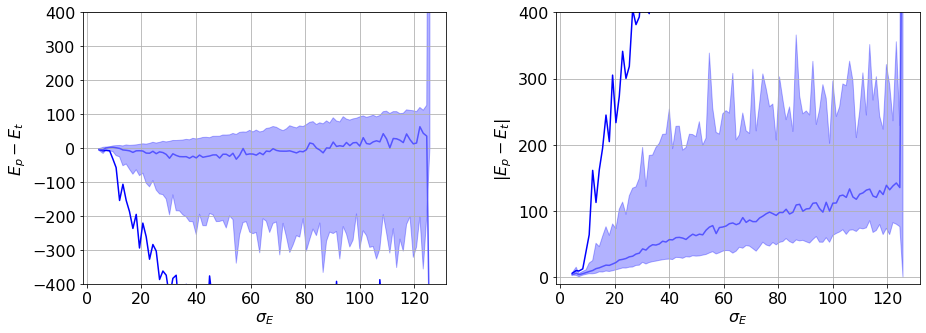

In [16]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

casos = int(0.5*len(energy))

z_msk = energy_std < np.sort(energy_std)[casos]

plt.subplot(1, 2, 1)

x, y, x_err, y_err = smooth_values (energy_std[z_msk], energy_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (energy_std[z_msk], energy_error[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-400, 400)
plt.ylabel('$E_p-E_t$')
plt.xlabel('$\sigma_E$')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)

x, y, x_err, y_err = smooth_values (energy_std[z_msk], energy_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median (energy_std[z_msk], energy_error_abs[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1, color='blue',alpha=0.3)

#plt.fill_between(x, y+y_err,y-y_err,color='blue',alpha=0.3)
plt.ylim(-10, 400)
plt.ylabel('$|E_p-E_t|$')
plt.xlabel('$\sigma_E$')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/std_energy.png')
plt.show(); #muestro las figuras

### Plot de Sigma relativa

Corto en función de la Sigma relativa  $\Rightarrow \sigma$/Energy$_p$

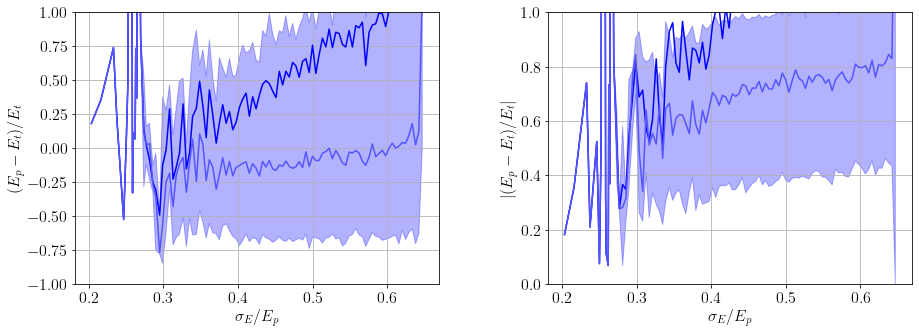

In [17]:
plt.close('all')

#Cambio el tamanyo de fuente
plt.rcParams.update({'font.size': 16})
matplotlib.rcParams['text.usetex'] = True

# Cambio el tamanyo de la figura
plt.figure(figsize=(15,5))

# Numero de intervalos en los que agrupo los datos
n_bins = 100

casos = int(0.5*len(energy))

z_msk = energy_std/energy_p < np.sort(energy_std/energy_p)[casos]

plt.subplot(1, 2, 1)

x, y, x_err, y_err = smooth_values ((energy_std/energy_p)[z_msk], energy_error_rel[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median ((energy_std/energy_p)[z_msk], energy_error_rel[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1,color='blue',alpha=0.3)

plt.ylim(-1, 1)
plt.ylabel('$(E_p-E_t)/E_t$')
plt.xlabel('$\sigma_E/E_p$')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplot(1, 2, 2)

x, y, x_err, y_err = smooth_values ((energy_std/energy_p)[z_msk], np.abs(energy_error_rel)[z_msk], n_bins) #cojo los valores
plt.plot(x, y, 'blue')
x, y, q1, q3 = smooth_median ((energy_std/energy_p)[z_msk], np.abs(energy_error_rel)[z_msk], n_bins) #cojo los valores
plt.plot(x, y, '#5555ff')
plt.fill_between(x, q3, q1, color='blue',alpha=0.3)

#plt.fill_between(x, y+y_err,y-y_err,color='blue',alpha=0.3)
plt.ylim(0, 1)
plt.ylabel('$|(E_p-E_t)/E_t|$')
plt.xlabel('$\sigma_E/E_p$')
#plt.legend(("Model error", 'Model error deviation'),loc='upper right')
plt.grid()

plt.subplots_adjust(hspace=0.25,wspace=0.3)
# Guardo la figura y la muestro
plt.savefig(str(folder_fig)+'/std_energy_rel.png')
plt.show(); #muestro las figuras

### Density plot Zenith

In [18]:
mu_temp.shape = (test_data.get_len())
sigma_temp.shape = (test_data.get_len())

Zenith median:  0.19457685538051897 

Zenith mean:  2.4100259812197136 

Zenith quartiles:  -0.5868836747207558 2.019235974832564 



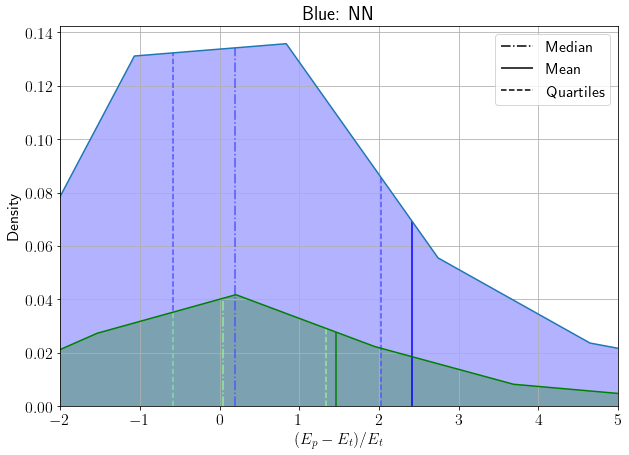

In [19]:
import seaborn as sns
import scipy

plt.close('all')
plt.figure(figsize=(10,7))

pct = 0.25
casos = int(pct*len(zeta))
Z_msk = sigma_temp/mu_temp < np.sort(sigma_temp/mu_temp)[casos]
#Z_msk = (test_data.get_len())

p = sns.kdeplot(data=[energy_error_rel, energy_error_rel[Z_msk]], common_grid=False,common_norm=True, bw_adjust=1.5)
kdeline = p.lines
x, y = kdeline[1].get_xdata(), kdeline[1].get_ydata()
xb, yb = kdeline[0].get_xdata(), kdeline[0].get_ydata()

kdeline[0].set_color('green')

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)
p.fill_between(xb, 0, yb, facecolor='green', alpha=0.3)

# Medians
median = np.median(energy_error_rel)
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.00000001,linestyles='dashdot', color='black', label='Median')
print('Zenith median: ', median,'\n')

median = np.median(energy_error_rel[Z_msk])
height = np.interp(median, xb, yb)
plt.vlines(median, 0, height,linestyles='dashdot', color='#90ee90')

#Means
mean = np.mean(energy_error_rel)
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.00000001, color='black', label='Mean')
print('Zenith mean: ', mean,'\n')

mean = np.mean(energy_error_rel[Z_msk])
height = np.interp(mean, xb, yb)
plt.vlines(mean, 0, height, color='green')

#Quartiles
q1, q3 = np.quantile(energy_error_rel,0.25), np.quantile(energy_error_rel,0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.00000001,linestyles='dashed', color='black', label='Quartiles')
print('Zenith quartiles: ', q1,q3,'\n')

q1, q3 = np.quantile(energy_error_rel[Z_msk],0.25), np.quantile(energy_error_rel[Z_msk],0.75)
height1, height3 = np.interp(q1, xb, yb), np.interp(q3, xb, yb)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#90ee90')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#90ee90')

plt.gca().set_xlim(-2,5)
#plt.gca().set_ylim(0.0,0.05)
plt.gca().set_title('Blue: NN')
#plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
#plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=11, endpoint=True ),minor=True)
plt.xlabel('$(E_p-E_t)/E_t$')
plt.grid(which='both',b=True)
plt.legend()
plt.savefig(str(folder_fig)+'/density_energy_rel.png')
plt.show;

Zenith median:  0.04663731480261803 

Zenith mean:  1.4664334805965415 

Zenith quartiles:  -0.5885787647935528 1.3326818959759903 



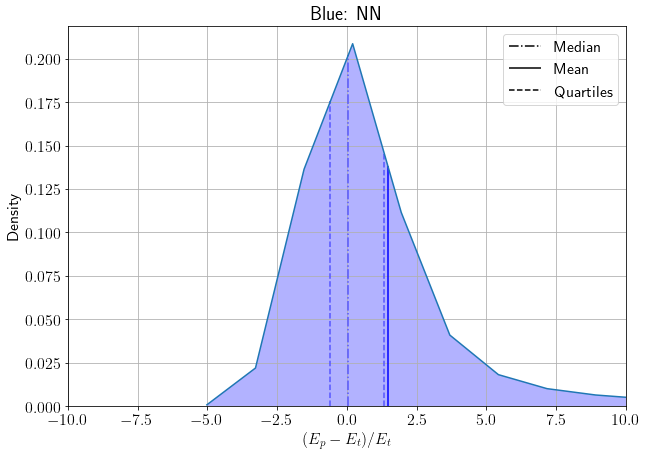

In [20]:
plt.close('all')
plt.figure(figsize=(10,7))

pct = 0.25
casos = int(pct*len(zeta))
Z_msk = sigma_temp/mu_temp < np.sort(sigma_temp/mu_temp)[casos]

p = sns.kdeplot(data=energy_error_rel[Z_msk],common_grid=True,common_norm=True, bw_adjust=1.5)
kdeline = p.lines
x, y = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)

# Medians
median = np.median(energy_error_rel[Z_msk])
height = np.interp(median, x, y)
plt.vlines(median, 0, height,linestyles='dashdot', color='#5555ff')
plt.vlines(median, 0, 0.00000001,linestyles='dashdot', color='black', label='Median')
print('Zenith median: ', median,'\n')

#Means
mean = np.mean(energy_error_rel[Z_msk])
height = np.interp(mean, x, y)
plt.vlines(mean, 0, height, color='blue')
plt.vlines(median, 0, 0.00000001, color='black', label='Mean')
print('Zenith mean: ', mean,'\n')


#Quartiles
q1, q3 = np.quantile(energy_error_rel[Z_msk],0.25), np.quantile(energy_error_rel[Z_msk],0.75)
height1, height3 = np.interp(q1, x, y), np.interp(q3, x, y)
plt.vlines(q1, 0, height1, linestyles='dashed', color='#5555ff')
plt.vlines(q3, 0, height3, linestyles='dashed', color='#5555ff')
plt.vlines(median, 0, 0.00000001,linestyles='dashed', color='black', label='Quartiles')
print('Zenith quartiles: ', q1,q3,'\n')


plt.gca().set_xlim(-10,10)
#plt.gca().set_ylim(0.0,0.05)
plt.gca().set_title('Blue: NN')
#plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
#plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=11, endpoint=True ),minor=True)
plt.xlabel('$(E_p-E_t)/E_t$')
plt.grid(which='both',b=True)
plt.legend()
plt.savefig(str(folder_fig)+'/density_energy_rel_50.png')
plt.show;

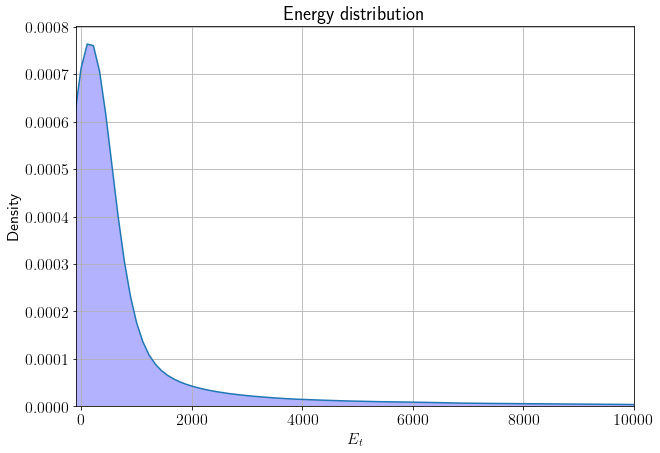

In [21]:
import seaborn as sns
import scipy

plt.close('all')
plt.figure(figsize=(10,7))


p = sns.kdeplot(data=energy,common_grid=True,common_norm=True, bw_adjust=1.5)
kdeline = p.lines
x, y = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)



plt.gca().set_xlim(-100,10000)
#plt.gca().set_ylim(0.0,0.05)
plt.gca().set_title('Energy distribution')
#plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
#plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=11, endpoint=True ),minor=True)
plt.xlabel('$E_t$')
plt.grid(which='both',b=True)
#plt.legend()
plt.savefig(str(folder_fig)+'/density_energy.png')
plt.show;

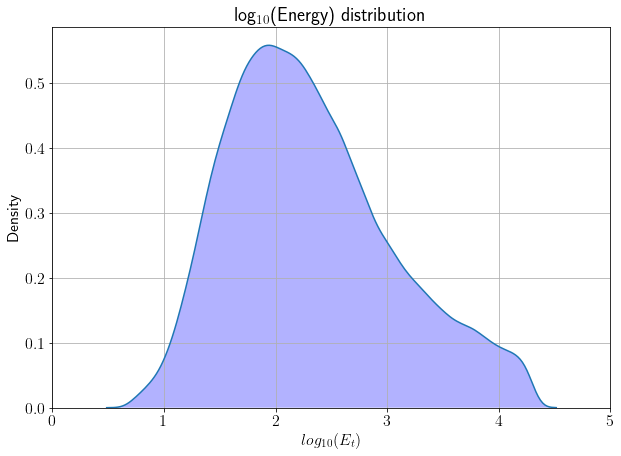

In [22]:
plt.close('all')
plt.figure(figsize=(10,7))


p = sns.kdeplot(data=np.log10(energy),common_grid=True,common_norm=True, bw_adjust=1.0)
kdeline = p.lines
x, y = kdeline[0].get_xdata(), kdeline[0].get_ydata()

p.fill_between(x, 0, y, facecolor='blue', alpha=0.3)

plt.gca().set_xlim(0,5)
#plt.gca().set_ylim(0.0,0.05)
plt.gca().set_title('log$_{10}$(Energy) distribution')
#plt.gca().set_xticks(np.linspace(0, 50, num=11, endpoint=True ),minor=True)
#plt.gca().set_xticks(np.linspace(0, 50, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=6, endpoint=True ))
#plt.gca().set_yticks(np.linspace(0, 0.05, num=11, endpoint=True ),minor=True)
plt.xlabel('$log_{10}(E_t)$')
plt.grid(which='both',b=True)
#plt.legend()
plt.savefig(str(folder_fig)+'/density_energy_log.png')
plt.show;

### Histogramas de Z

60000 120000 0.5
30000 120000 0.25


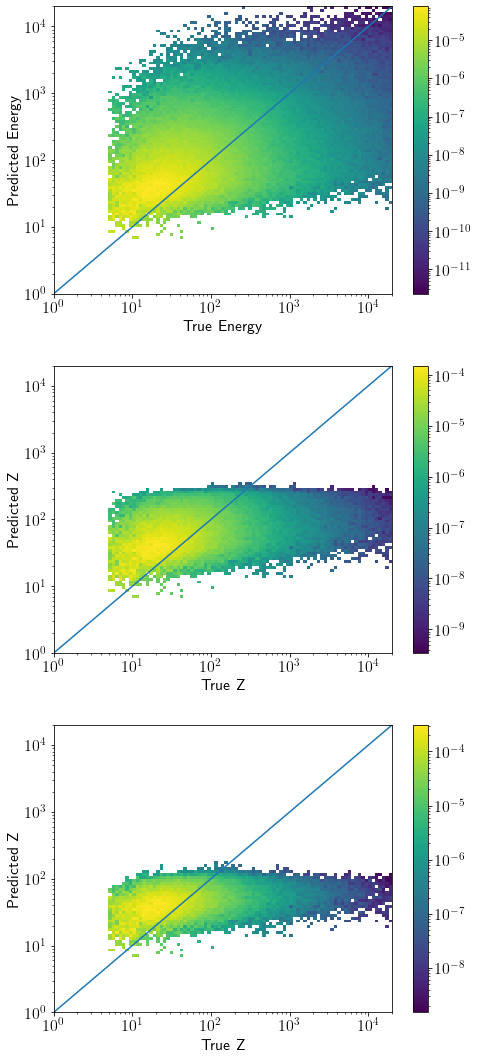

In [23]:
# Histograma de Z cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

#n_bins = 100

n_bins = np.logspace(np.log10(1.0), np.log10(20000.0), 100)

energy_p[energy_p>20000]=20000

plt.subplot(3, 1, 1)
plt.hist2d(energy, energy_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Energy')
plt.xlabel('True Energy')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = energy_std < np.sort(energy_std)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = energy_std < np.sort(energy_std)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_energy_std.png')
plt.show(); #muestro las figuras

60000 120000 0.5
30000 120000 0.25


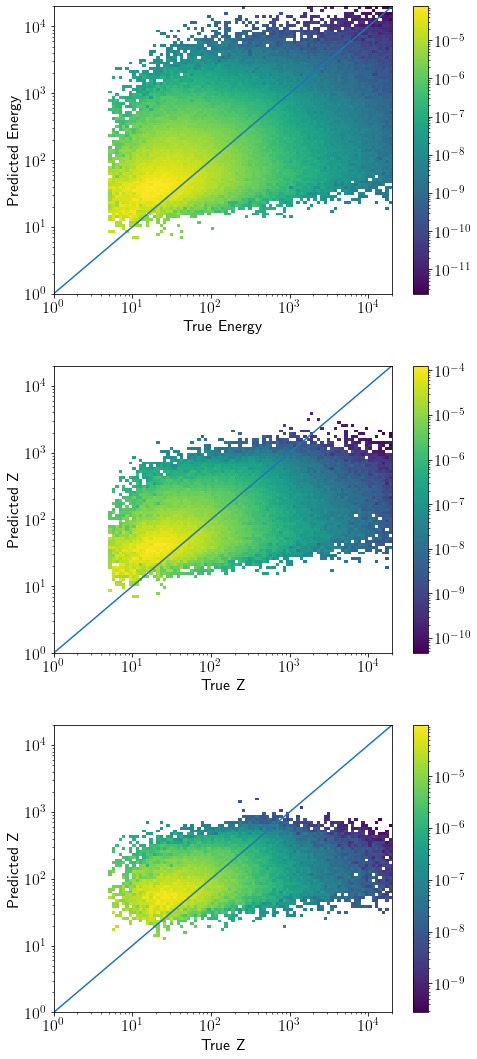

In [24]:
# Histograma de Z cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

#n_bins = 100

n_bins = np.logspace(np.log10(1.0), np.log10(20000.0), 100)

energy_p[energy_p>20000]=20000

plt.subplot(3, 1, 1)
plt.hist2d(energy, energy_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Energy')
plt.xlabel('True Energy')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = energy_std_rel < np.sort(energy_std_rel)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = energy_std_rel < np.sort(energy_std_rel)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_energy_std_rel.png')
plt.show(); #muestro las figuras

60000 120000 0.5
30000 120000 0.25


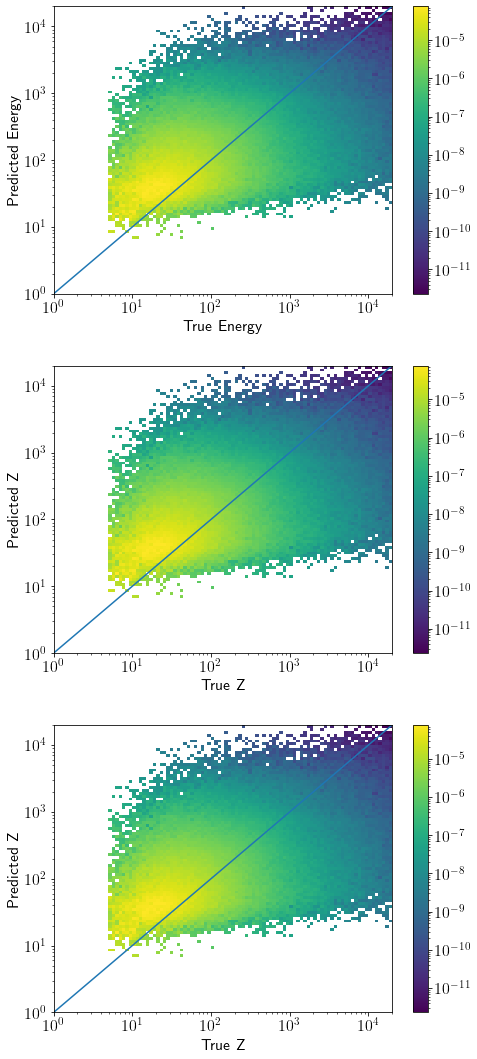

In [25]:
# Histograma de Z cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

#n_bins = 100

n_bins = np.logspace(np.log10(1.0), np.log10(20000.0), 100)

energy_p[energy_p>20000]=20000

plt.subplot(3, 1, 1)
plt.hist2d(energy, energy_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Energy')
plt.xlabel('True Energy')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = sigma_temp < np.sort(mu_temp)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = sigma_temp < np.sort(mu_temp)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Z')
plt.xlabel('True Z')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_energy_std_log.png')
plt.show(); #muestro las figuras

60000 120000 0.5
30000 120000 0.25


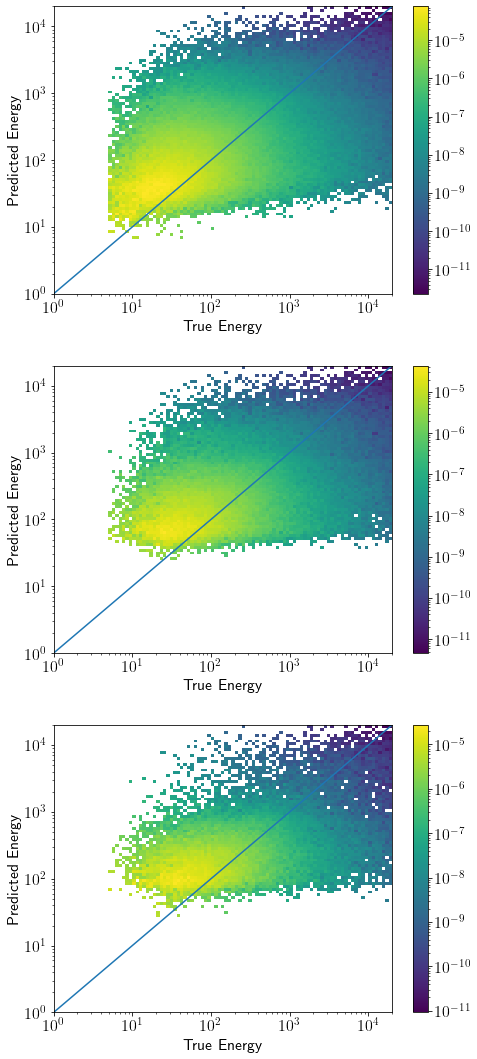

In [26]:
# Histograma de Z cortado con eps
plt.close('all')
plt.figure(figsize=(7,15))
plt.rcParams.update({'font.size': 16})

#n_bins = 100

n_bins = np.logspace(np.log10(1.0), np.log10(20000.0), 100)

energy_p[energy_p>20000]=20000

plt.subplot(3, 1, 1)
plt.hist2d(energy, energy_p, bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Energy')
plt.xlabel('True Energy')
plt.colorbar()

pct = 0.50
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = sigma_temp/mu_temp < np.sort(sigma_temp/mu_temp)[casos]

plt.subplot(3, 1, 2)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Energy')
plt.xlabel('True Energy')
plt.colorbar()

pct = 0.25
casos = int(pct*len(zeta))
print(casos, len(zeta), casos/len(zeta))

Z_msk = sigma_temp/mu_temp < np.sort(sigma_temp/mu_temp)[casos]

plt.subplot(3, 1, 3)
plt.hist2d(energy[Z_msk], energy_p[Z_msk], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
plt.yscale('log')
plt.xscale('log')
plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.ylabel('Predicted Energy')
plt.xlabel('True Energy')
plt.colorbar()
plt.tight_layout()

plt.subplots_adjust(hspace=0.25)
plt.savefig(str(folder_fig)+'/colors_75_energy_std_rel_log.png')
plt.show(); #muestro las figuras

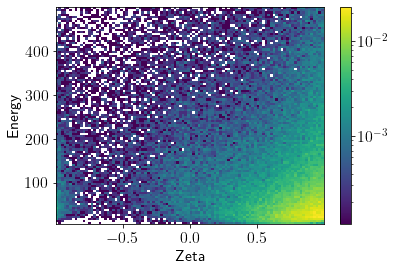

In [27]:
plt.close('all')
n_bins = 100
plt.hist2d(zeta[energy<500], energy[energy<500], bins = n_bins, density = True, norm = matplotlib.colors.LogNorm())
#plt.xlim(0,20000)
#plt.ylim(0,20000)
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Energy')
plt.xlabel('Zeta')
plt.colorbar()
plt.show(); #muestro las figuras